EDA
---

Our EDA will take several steps:

1. Feature Preparation
2. Seek Correlations
3. Additional Feature Engineering

Step 0: Packages and Data
---

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from sklearn import preprocessing
from statsmodels.graphics.regressionplots import *

import matplotlib.pyplot as plt
import seaborn as sns


sns.set_context('notebook')
sns.set_palette('GnBu')

In [2]:
train_set = pd.read_json('../data/interim/Step 1 - Train Set.json', orient='records')
test_set = pd.read_json('../data/interim/Step 1 - Test Set.json', orient='records')
total_set = pd.read_json('../data/interim/Step 1 - Total Set.json', orient='records')

Step 1: Feature Preparation
---
I noted some odd things about some of the features during wrangling. Let's do something about them.

In [3]:
# Some of our 'categorical' (dtype='object') variables are essentially linear measures of
# quality, so they could easily be changed into numeric features.

# I've identified them by skimming the data_description file.

# basic_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
# basic_features = ['ExterQual_dict', 'ExterCond_dict', 'HeatingQC_dict', 'KitchenQual_dict']

# ext_dct = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
# ext_features = ['BsmtQual_dict', 'BsmtCond_dict', 'FireplaceQu_dict', 'GarageQual_dict', 'GarageCond_dict']

# LotShape_dict = {'Reg':4, 'IR1':3, 'IR2':2, 'IR3':1}
# BsmtExposure_dict = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
# BsmtFinType1_dict = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
# BsmtFinType2_dict = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
# PavedDrive_dict = {'Y':3, 'P':2, 'N':1}
# PoolQC_dict = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0}

# # Maybe make this one logarithimic??? I imagine the scale is fascinating.
# Functional_dict = {'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1}

# # Consider exponential for this...
# GarageFinish_dict = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}

# NOTE: Actually, many of these are universally applicable... let's just do them all in one dict.

replacement_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, 'Reg':4, 'IR1':3, 'IR2':2, 'IR3':1, \
                    'Av':3, 'Mn':2, 'No':1, 'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, \
                    'Y':3, 'P':2, 'N':1, 'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, \
                    'Sev':2, 'Sal':1,'Fin':3, 'RFn':2}

Now we perform the replacement.

In [4]:
total_set.replace(replacement_dict, inplace=True)
train_set = total_set[total_set['set'] == 'train']
test_set = total_set[total_set['set'] == 'test']

Step 2: Seek Correlations
---

First off, let's look at all our numeric variables' correlations.

We can find them by data type, then remove the non-feature 'Id' and 'index' columns.

In [5]:
numeric_features = [column for column in train_set.columns if train_set[column].dtype in ['int64', 'float64']]
numeric_features.remove('Id')
numeric_features.remove('index')

Now we can heatmap them against each other.

Since we're concerned with the strength of correlations, not the direction, let's take the absolute value of the correlation coefficients and plot them with a sequential pallette.

We can pay special attention to the last row, which clearly indicates each variable's correlation to the label.

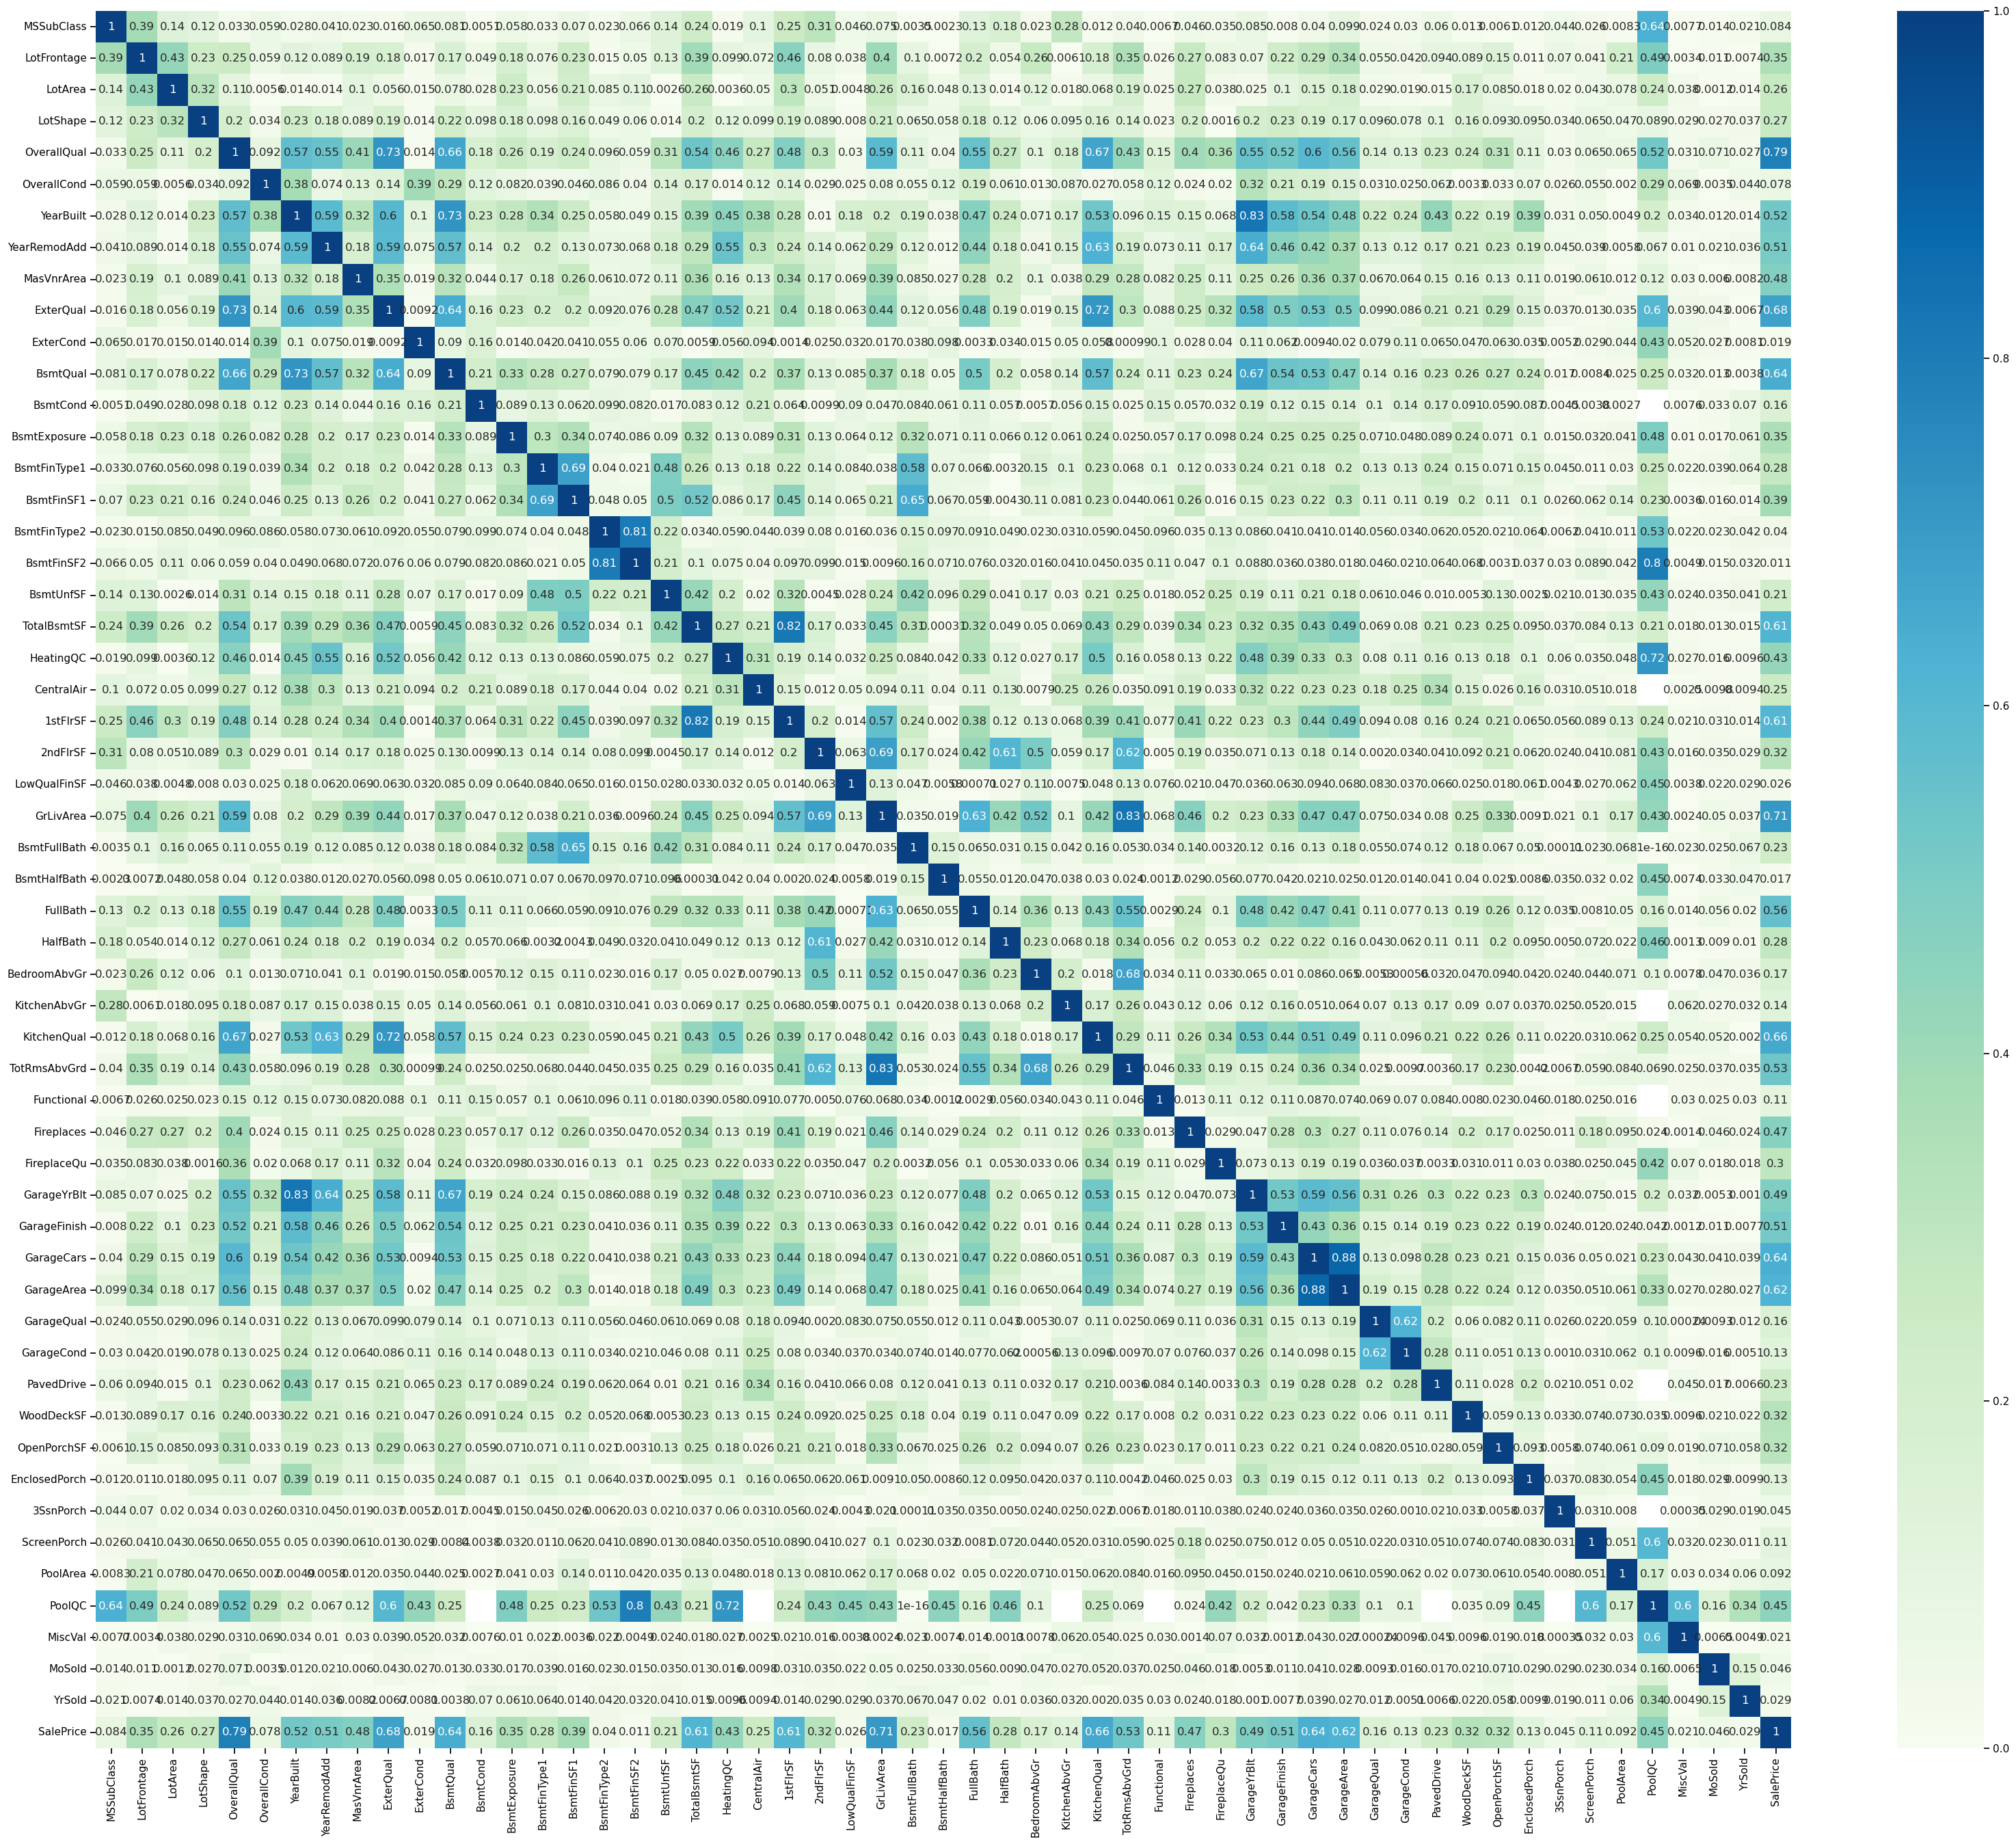

In [6]:
corr_vals = train_set[numeric_features].corr()
abs_corr_vals = corr_vals.apply(abs)

plt.figure(figsize=(40,33))
sns.heatmap(abs_corr_vals, cmap='GnBu', annot=True)
sns.set_context('notebook')
plt.savefig('heatmap.png')
plt.show()

That's neat, but it's super big and hard to read. Let's isolate which variables are most closely correlated to the label and look at them specifically.

I'll arbitrarily set a threshold of pearson > 0.5 for 'closely correlated.'

In [7]:
abs_corrs = abs_corr_vals['SalePrice']

high_corrs = [item[0] for item in abs_corrs.items() if item[1] > 0.5]

high_corrs.remove('SalePrice')

ordered_high_corrs = sorted(high_corrs, key=lambda x: abs_corrs[x], reverse=True)

abs_corrs[ordered_high_corrs]

OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
BsmtQual        0.644019
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
GarageFinish    0.513105
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Now let's explore them. With plots!

We'll do it one by one, for easy commenting and note-taking.

---

OverallQual

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

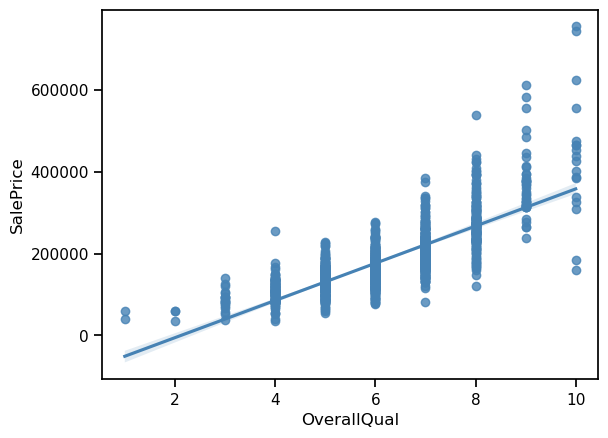

In [8]:
sns.regplot(x=train_set['OverallQual'], y=train_set['SalePrice'], color='steelblue')

A very clear positive correlation!

A few notes:

1. The relationship looks heteroskedastic. Variance increases with OverallQual.

2. It looks like two SalePrice values are clear outliers. Let's keep an eye on them as we move forward.

---

GrLivArea

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

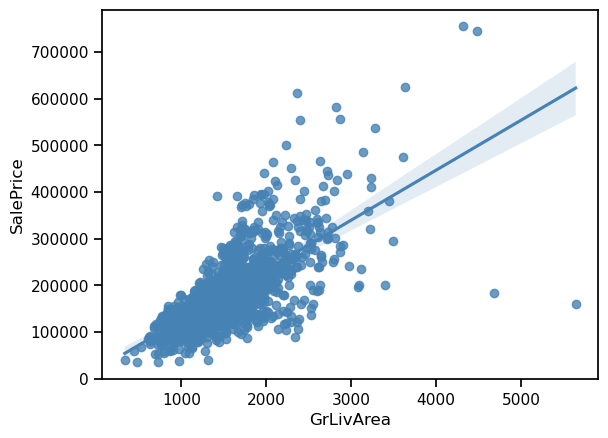

In [9]:
sns.regplot(x=train_set['GrLivArea'], y=train_set['SalePrice'], color='steelblue')

1. We have two GrLivArea outliers. Consider removing them, or coercing them to a value closer to the regression line. We will explore this later when we look at leverage.

---

I've noticed that 'GarageCars' and 'GarageArea' are both on the list, but they're obviously very closely correlated. Let's look at them together.

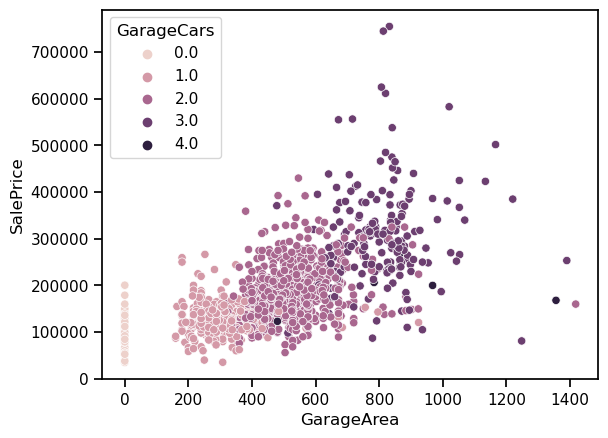

In [10]:
sns.scatterplot(x=train_set['GarageArea'], y=train_set['SalePrice'], hue=train_set['GarageCars'])

plt.legend(title='GarageCars')

1. Some of the points don't make sense. How can a 3- or 4-car garage have the same area as a 1-car garage? We should examine that record and decide what to do with that value.

2. Or, perhaps, we should discard 'GarageCars' altogether in favor of 'GarageArea.'

3. This relationship is also heteroskedastic.

---

TotalBsmtSF

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

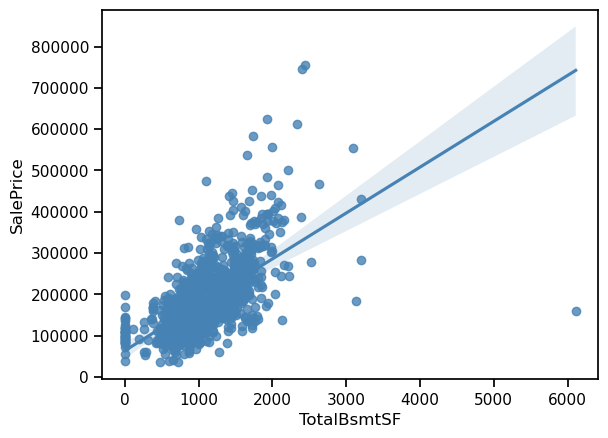

In [11]:
sns.regplot(x=train_set['TotalBsmtSF'], y=train_set['SalePrice'], color='steelblue')

Looks good. We can handle those outliers when we examine leverage.

---

1stFlrSF

<Axes: xlabel='1stFlrSF', ylabel='SalePrice'>

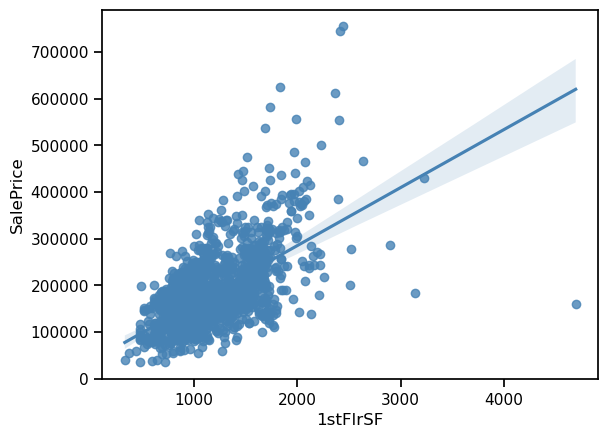

In [12]:
sns.regplot(x=train_set['1stFlrSF'], y=train_set['SalePrice'], color='steelblue')

Again with the vertical outlier, at about the same price point... possibly the same record? Let's check it out in a bit.

---

FullBath

<Axes: xlabel='FullBath', ylabel='SalePrice'>

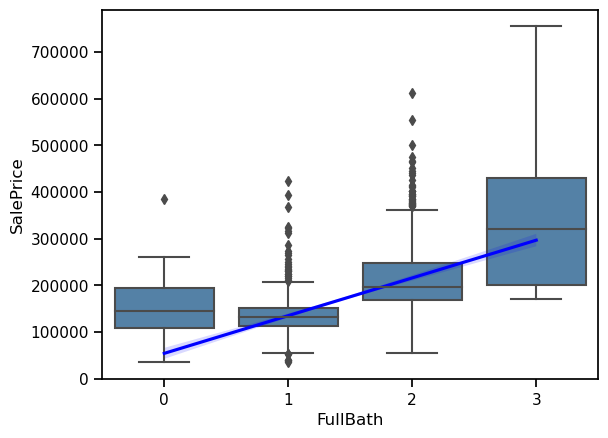

In [13]:
sns.boxplot(x=train_set['FullBath'], y=train_set['SalePrice'], color='steelblue')
sns.regplot(x=train_set['FullBath'], y=train_set['SalePrice'], marker='', color='blue')

Seems like the relationship between 1-3 is fairly clear-cut, while 0 is more complicated. Perhaps 0 is a common error value? It looks closest to 1, so maybe I should impute all 0s to 1s.

This regression line goes close to the mean of all values except '0'. Let's see if the mean of '0' is all that different from the mean of '1'; if it's not, then we might get slightly more accurate by combining them.

In [14]:
# df = total_set[['FullBath', 'SalePrice']]

# dict = {'0': 1}

# df.replace(dict, inplace=True)

print('Mean for 0: '+str(total_set[total_set['FullBath'] == 0]['SalePrice'].mean()))
print('Mean for 1: '+str(total_set[total_set['FullBath'] == 1]['SalePrice'].mean()))

Mean for 0: 165200.88888888888
Mean for 1: 134751.44


In [15]:
total_set[total_set['FullBath'] == 0]['set'].value_counts()

train    9
test     3
Name: set, dtype: int64

A full 30,000 higher! But there's only 12 of them. So if we add them to 1, it won't change the mean of 1 barely at all, but it should increase the accuracy of all predictions for 0. Maybe we can A/B test that later.

---

TotRmsAbvGrd

<Axes: xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

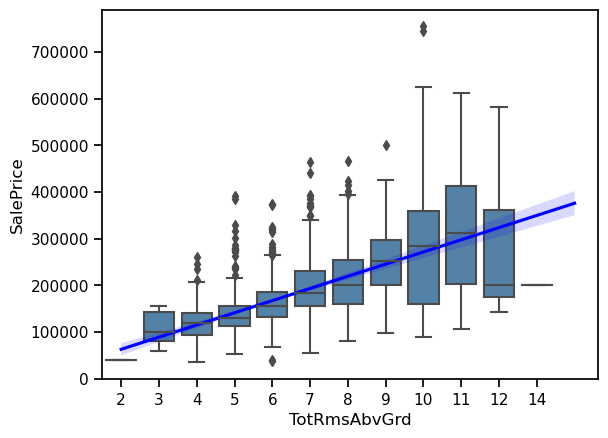

In [16]:
# I have no idea why subtracting 2 from the x variable makes the regplot line up, but it does. What fun!

sns.boxplot(x=train_set['TotRmsAbvGrd'], y=train_set['SalePrice'], color='steelblue')
sns.regplot(x=train_set['TotRmsAbvGrd'] - 2, y=train_set['SalePrice'], marker='', color='blue')

Fascinating! It actually seems to go down after 11, though the mean of 12 is still close to 11's IQR.

But, are these significant? Let's see the value counts one more time.

In [17]:
rm_ct_cts = total_set['TotRmsAbvGrd'].value_counts()
rm_ct_cts

6     844
7     649
5     583
8     347
4     196
9     143
10     80
11     32
3      25
12     16
2       1
14      1
13      1
15      1
Name: TotRmsAbvGrd, dtype: int64

In [18]:
total_set[total_set['TotRmsAbvGrd'].isin([2, 14, 13, 15, 12])]['set'].value_counts()

train    13
test      7
Name: set, dtype: int64

It looks like we don't have enough data to make any reasonable conclusions about the true means of 2, possibly 12, and 13-15. Maybe we should just omit those.

---

YearBuilt

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

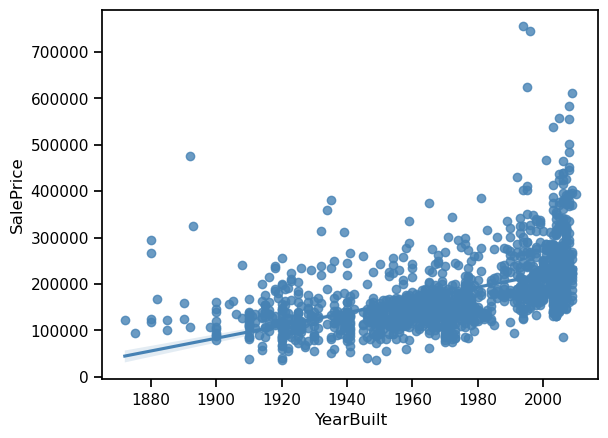

In [19]:
sns.regplot(x=train_set['YearBuilt'], y=train_set['SalePrice'], color='steelblue')

This relationship looks strong but not entirely linear. We might have to get a little creative with specifically how we model this.

---

YearRermodAdd

<Axes: xlabel='YearRemodAdd', ylabel='SalePrice'>

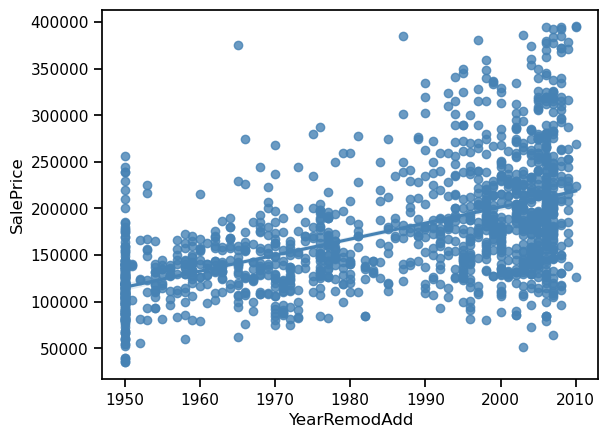

In [20]:
sns.regplot(x=train_set[train_set['SalePrice'] < 400000]['YearRemodAdd'], y=train_set[train_set['SalePrice'] < 400000]['SalePrice'], color='steelblue')

Talk about heteroskedastic! I hope at least some of our models can determine a reason for that crazy variance in the high values.

---

ExterQual

<Axes: xlabel='ExterQual', ylabel='SalePrice'>

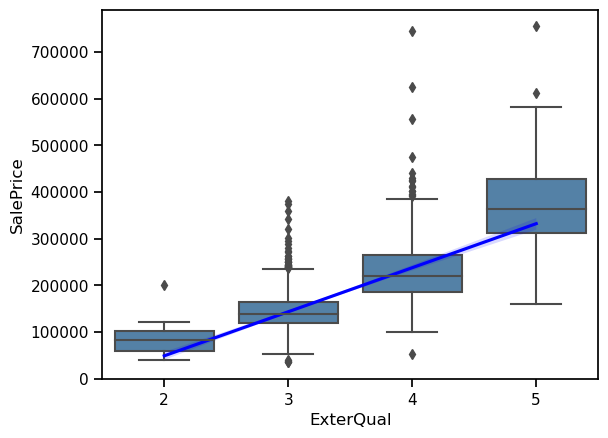

In [21]:
sns.boxplot(x=train_set['ExterQual'], y=train_set['SalePrice'], color='steelblue')

sns.regplot(x=train_set['ExterQual'] - 2, y=train_set['SalePrice'], marker='', color='blue')

---

KitchenQual

<Axes: xlabel='KitchenQual', ylabel='SalePrice'>

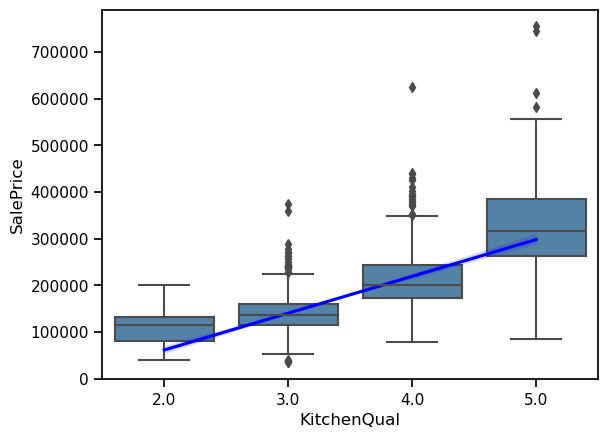

In [22]:
sns.boxplot(x=train_set['KitchenQual'], y=train_set['SalePrice'], color='steelblue')
sns.regplot(x=train_set['KitchenQual'] - 2, y=train_set['SalePrice'], marker='', color='blue')

It's like deja vu! KitchenQual and ExterQual have almost the exact same relationship to SalePrice.

---

BsmtQual

<Axes: xlabel='BsmtQual', ylabel='SalePrice'>

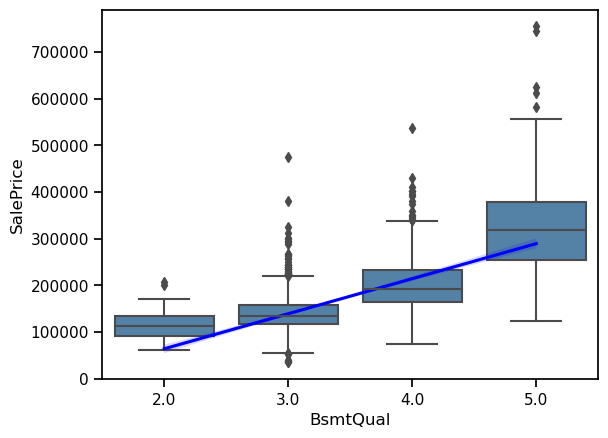

In [23]:
sns.boxplot(x=train_set['BsmtQual'], y=train_set['SalePrice'], color='steelblue')
sns.regplot(x=train_set['BsmtQual'] - 2, y=train_set['SalePrice'], color='blue', marker='')

Honestly guys, this is getting to be a lot. So many spookily similar correlations. I guess sellers who care about 'qual' do it fairly consistently across the board.

---

GarageFinish

c:\Users\Josh\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 63.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Josh\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Josh\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 21.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 3000x3000 with 0 Axes>

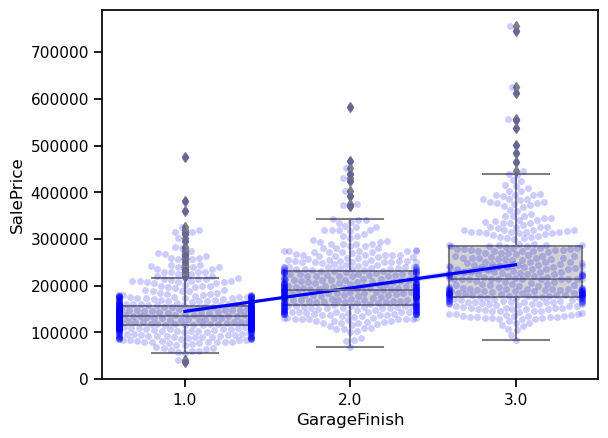

<Figure size 3000x3000 with 0 Axes>

In [24]:
# Honestly I'm just playing around with plots at this point.

sns.boxplot(x=train_set['GarageFinish'], y=train_set['SalePrice'], color='lightgray')
sns.regplot(x=train_set['GarageFinish'] - 1, y=train_set['SalePrice'], color='blue', marker='')
sns.swarmplot(x=train_set['GarageFinish'] - 1, y=train_set['SalePrice'], color='blue', alpha=0.2)

plt.figure(figsize=(30, 30))

It's worth noting that all of these distributions skew to the right, since home prices have no theoretical upper limit but a hard lower limit.

---

Now we can look for strong relationships between the features.

I'll arbitrarily define 'strong relationships' as pearson > 0.5.

In [25]:
corr_vals = set()

i = 0

corr_df = train_set[numeric_features].corr().drop('SalePrice')

for index, row in corr_df.iterrows() :
    for feature in numeric_features[0:i] :
        if row[feature] > 0.5 and index != feature :
            corr_vals.add(((index, feature), row[feature]))
    i += 1

abs_corr_vals = []

for item in corr_vals :
      abs_corr_vals.append((item[0], abs(item[1])))

abs_corr_vals = sorted(abs_corr_vals, key = lambda x: x[1], reverse=True)

abs_corr_vals

[(('GarageArea', 'GarageCars'), 0.882475414281462),
 (('GarageYrBlt', 'YearBuilt'), 0.8256674841743408),
 (('TotRmsAbvGrd', 'GrLivArea'), 0.8254893743088425),
 (('1stFlrSF', 'TotalBsmtSF'), 0.8195299750050339),
 (('BsmtFinSF2', 'BsmtFinType2'), 0.8052124017068031),
 (('ExterQual', 'OverallQual'), 0.7262784907641405),
 (('BsmtQual', 'YearBuilt'), 0.7255627116083795),
 (('PoolQC', 'HeatingQC'), 0.7202771009357686),
 (('KitchenQual', 'ExterQual'), 0.7161221955033013),
 (('GrLivArea', '2ndFlrSF'), 0.6875010641666033),
 (('BsmtFinSF1', 'BsmtFinType1'), 0.687149229848328),
 (('TotRmsAbvGrd', 'BedroomAbvGr'), 0.676619935742649),
 (('KitchenQual', 'OverallQual'), 0.6733307811877888),
 (('GarageYrBlt', 'BsmtQual'), 0.6708588128400641),
 (('BsmtQual', 'OverallQual'), 0.6646495818720195),
 (('BsmtFullBath', 'BsmtFinSF1'), 0.6492117535742649),
 (('BsmtQual', 'ExterQual'), 0.6448162201732431),
 (('GarageYrBlt', 'YearRemodAdd'), 0.6422767797035356),
 (('PoolQC', 'MSSubClass'), 0.6350011650955932),
 

That's a lot! Too many to handle manually. Let's narrow it down to the ones that we know to be highly correlated to the label.

In [26]:
double_corrs = []

for item in abs_corr_vals :
    if item[0][0] in high_corrs and item[0][1] in high_corrs :
        double_corrs.append(item)

len(double_corrs)

34

That's so many! So much intercorrelation between our important variables could be a serious problem.

Unfortunately I don't think I can sort it all out manually. Let's just hit the highlights and hope the automated modelers can sort out the rest.

C:\Users\Josh\AppData\Local\Temp\ipykernel_33756\1340418293.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sns.heatmap(total_set[double_corr_set].corr())


<Axes: >

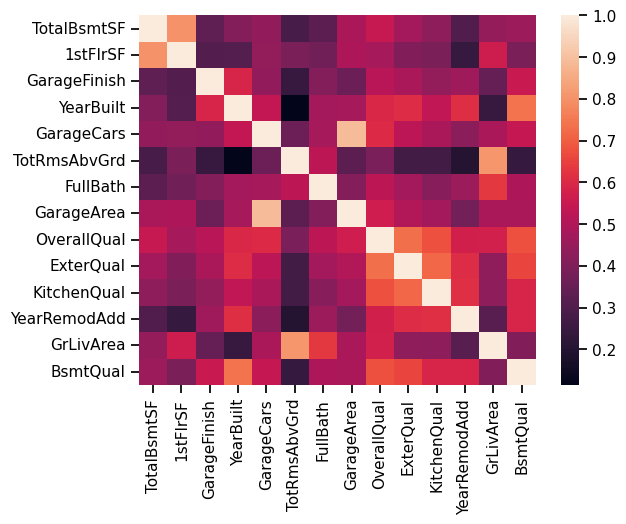

In [27]:
double_corr_set = set()

for item in double_corrs :
    double_corr_set.add(item[0][0])
    double_corr_set.add(item[0][1])

sns.heatmap(total_set[double_corr_set].corr())

In [28]:
[x for x in double_corrs if x[1] > 0.7]

[(('GarageArea', 'GarageCars'), 0.882475414281462),
 (('TotRmsAbvGrd', 'GrLivArea'), 0.8254893743088425),
 (('1stFlrSF', 'TotalBsmtSF'), 0.8195299750050339),
 (('ExterQual', 'OverallQual'), 0.7262784907641405),
 (('BsmtQual', 'YearBuilt'), 0.7255627116083795),
 (('KitchenQual', 'ExterQual'), 0.7161221955033013)]

---

GarageArea vs GarageCars

As noted above, these are incredibly correlated. Let's just drop GarageCars, since it's a bit less precise to model.

In [29]:
discarded_features = ['GarageCars']

---

GarageYrBuilt vs YearBuilt

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

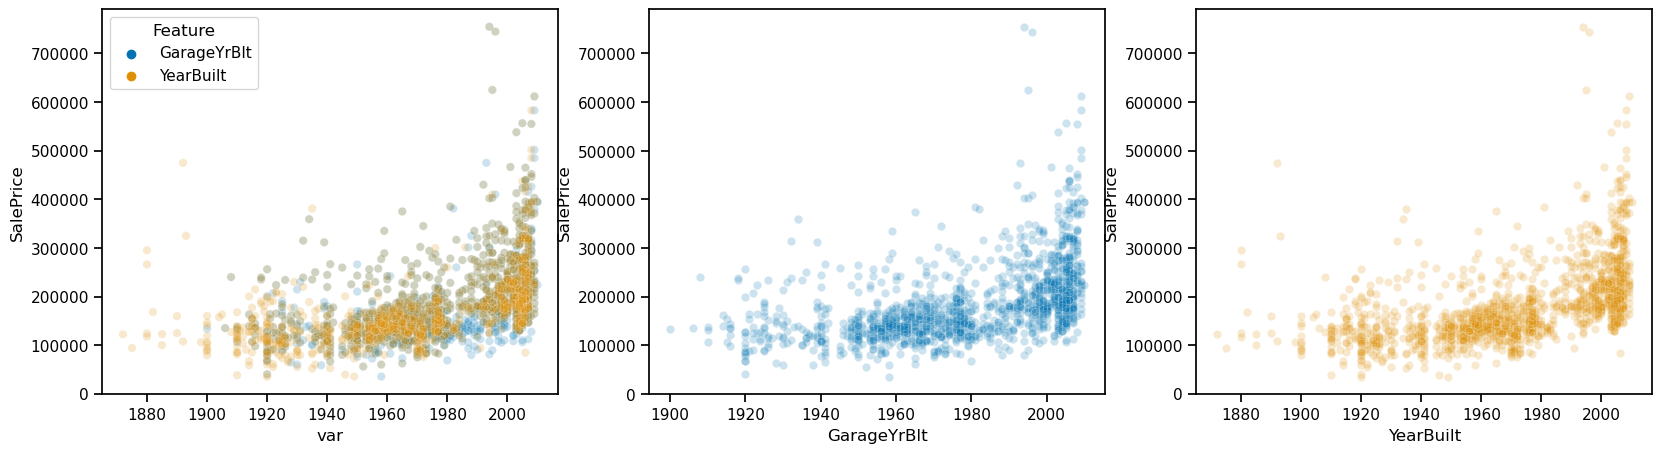

In [30]:
df_1 = pd.DataFrame(total_set[['GarageYrBlt', 'SalePrice']])
df_1.columns = ['var', 'SalePrice']
df_1['Feature'] = 'GarageYrBlt'

df_2 = pd.DataFrame(total_set[['YearBuilt', 'SalePrice']])
df_2.columns = ['var', 'SalePrice']
df_2['Feature'] = 'YearBuilt'

df = pd.concat([df_1, df_2])

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.scatterplot(x=df['var'], y=df['SalePrice'], hue=df['Feature'], palette='colorblind', alpha=0.2, ax=ax[0])
sns.scatterplot(x=total_set['GarageYrBlt'], y=total_set['SalePrice'], color=sns.color_palette('colorblind')[0], alpha=0.2, ax=ax[1])
sns.scatterplot(x=total_set['YearBuilt'], y=total_set['SalePrice'], color=sns.color_palette('colorblind')[1], alpha=0.2, ax=ax[2])



It's a wash, so we can safely discard one. We already know that 'YearBuilt' more closely corresponds to the label, so let's drop 'GarageYrBlt'.

In [31]:
discarded_features.append('GarageYrBlt')

---

'TotRmsAbvGrd', 'GrLivArea'

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

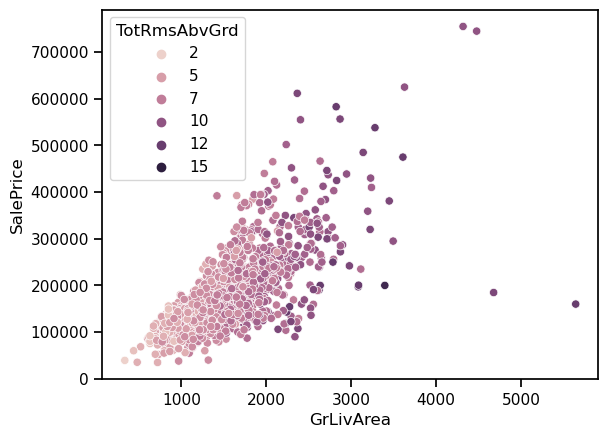

In [32]:
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='TotRmsAbvGrd', data=total_set)

This looks like a similar situation to garage size vs garage cars. Let's use the same solution - GrLivArea more closely correlates, so let's drop the other.

In [33]:
discarded_features.append('TotRmsAbvGrd')

---

'1stFlrSF', 'TotalBsmtSF'

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

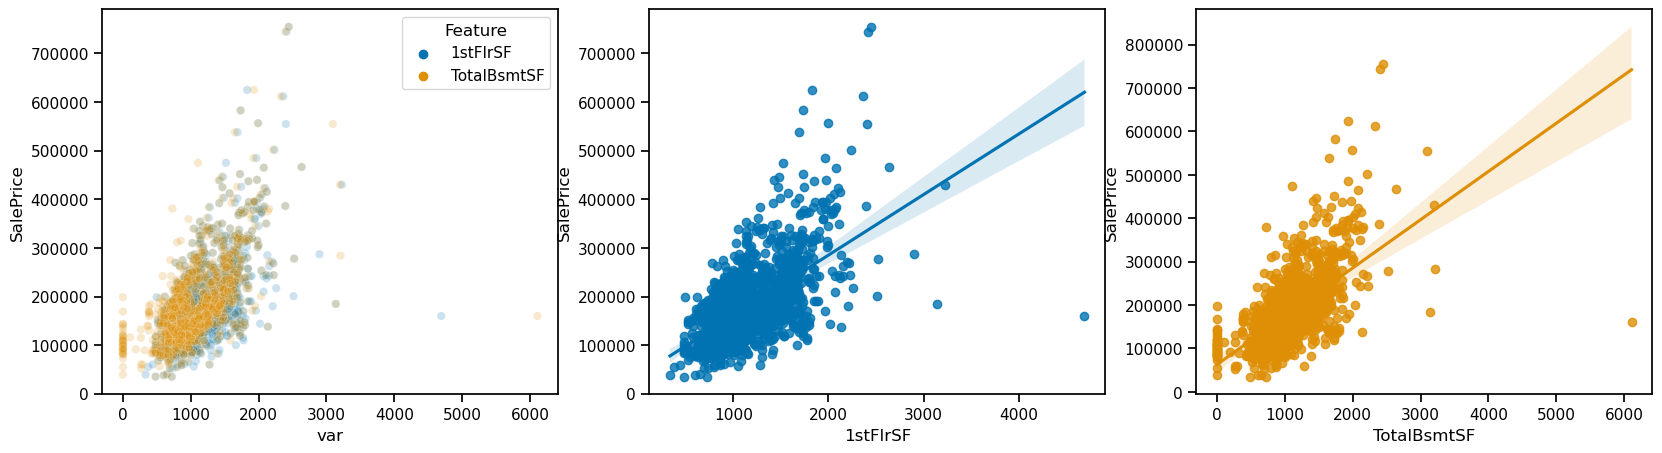

In [34]:
df_1 = pd.DataFrame(total_set[['1stFlrSF', 'SalePrice']])
df_1.columns = ['var', 'SalePrice']
df_1['Feature'] = '1stFlrSF'

df_2 = pd.DataFrame(total_set[['TotalBsmtSF', 'SalePrice']])
df_2.columns = ['var', 'SalePrice']
df_2['Feature'] = 'TotalBsmtSF'

df = pd.concat([df_1, df_2])

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.scatterplot(x=df['var'], y=df['SalePrice'], hue=df['Feature'], palette='colorblind', alpha=0.2, ax=ax[0])
sns.regplot(x=total_set['1stFlrSF'], y=total_set['SalePrice'], color=sns.color_palette('colorblind')[0], ax=ax[1])
sns.regplot(x=total_set['TotalBsmtSF'], y=total_set['SalePrice'], color=sns.color_palette('colorblind')[1], ax=ax[2])



We know that TotalBsmtSF is .01 more correlated to the label. This might be because:

1. The basement size, if existing, is closely correlated to 1st floor size, so their relationship to the label will be the same.

2. A house of any size with a basement will be more valuable than the same house without a basement.

So, including the basement sf instead of the first floor sf actually allows us to include slightly more data about the house.

On the other hand, we might consider making 'has a basement' a standalone binary variable... let's explore that.

C:\Users\Josh\AppData\Local\Temp\ipykernel_33756\2502182461.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HasBasement'] = df['TotalBsmtSF'] != 0


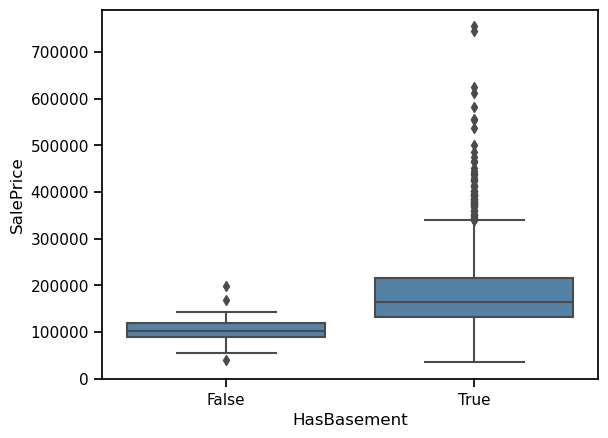

             1stFlrSF  TotalBsmtSF  SalePrice  HasBasement
1stFlrSF     1.000000     0.801670   0.605852     0.004876
TotalBsmtSF  0.801670     1.000000   0.613581     0.395529
SalePrice    0.605852     0.613581   1.000000     0.152829
HasBasement  0.004876     0.395529   0.152829     1.000000


In [35]:
df = total_set[['1stFlrSF', 'TotalBsmtSF', 'SalePrice']]
# df = df[df['TotalBsmtSF'] != 0]
df['HasBasement'] = df['TotalBsmtSF'] != 0

sns.boxplot(x='HasBasement', y='SalePrice', data=df, color='steelblue')

plt.show()

print(df.corr())

We're doing a lot of work to get nowhere. Let's just use the more highly-correlated feature and get on with our lives.

In [36]:
discarded_features.append('1stFlrSF')

---

'BsmtQual', 'YearBuilt'

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

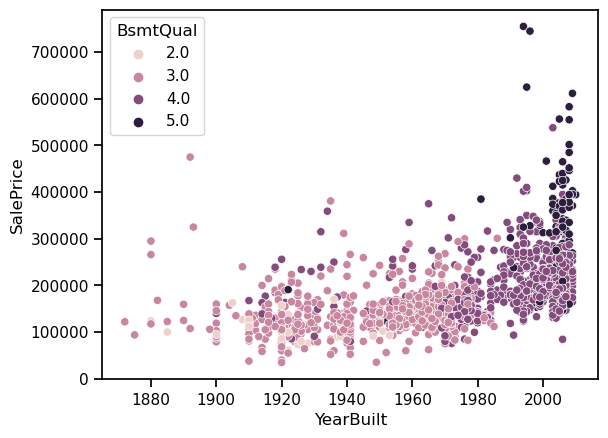

In [37]:
sns.scatterplot(x='YearBuilt', y='SalePrice', hue='BsmtQual', data=total_set)

Fascinating! I was troubled by the wild price variance on more recent houses, but this seems to suggest an explanation:

There is greater variation in quality in newer houses than in older houses, which has a great effect on the variance of housing prices for newer homes.

This sounds like the beginning of a hypothesis! Let's check our other 'quality' variables to see if this holds.

In [38]:
qualities = ['OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual']

for index, row in total_set[qualities].iterrows() :
    for quality in qualities :
        if row[quality] == 'RL' :
            print(row)

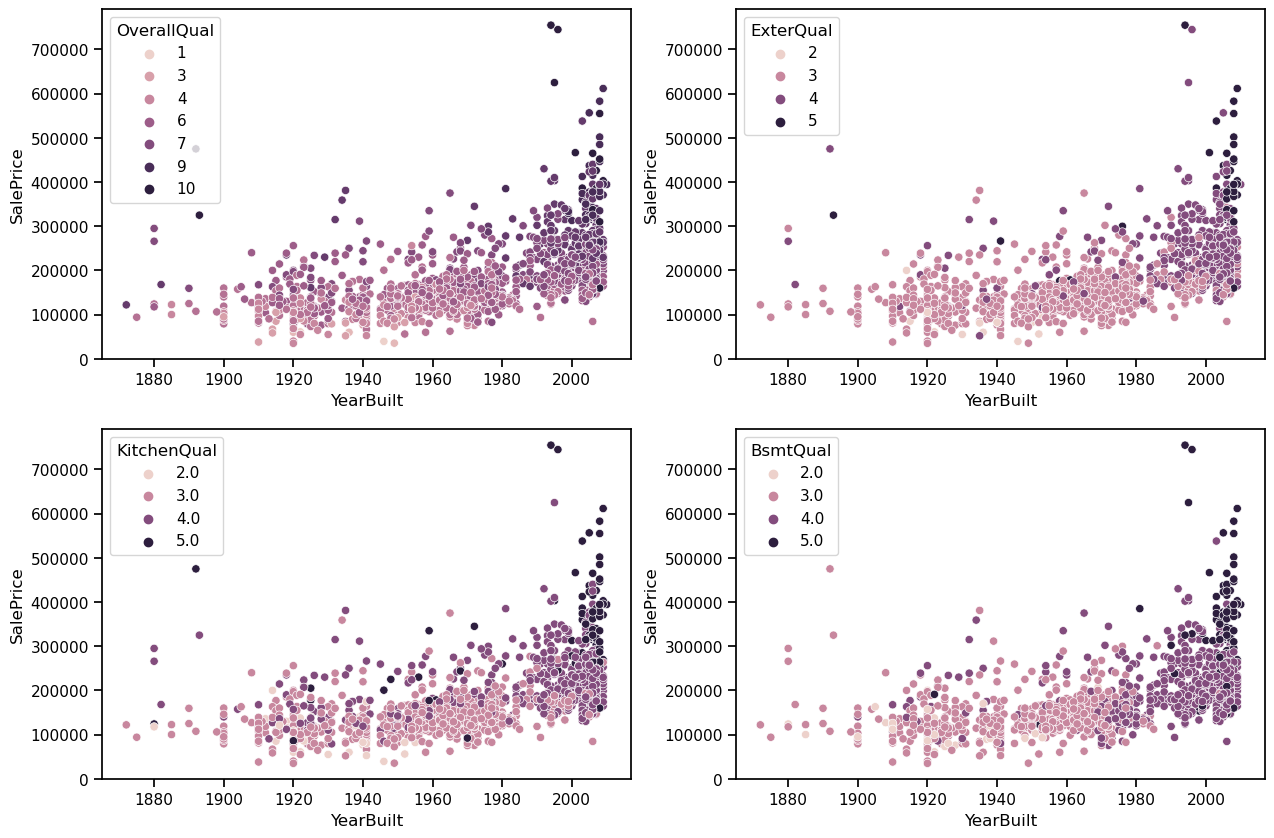

In [39]:
qualities = ['OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual']

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

for i in range(len(ax)) :
    sns.scatterplot(x='YearBuilt', y='SalePrice', hue=qualities[i], data=total_set, ax=ax[i])

plt.show()

The relationship really does seem to hold! It seems a huge portion of the correlation between YearBuilt and SalePrice can be explained by the Quality variables, as newer homes tend to have higher Quality scores. Perhaps it's better to ignore YearBuilt altogether and just use OverallQual (which also conveniently has twice as many gradations as the other Quality scores).

KitchenQual seems really interesting - it appears to be the most-updated thing, even in old houses. That is to say, more older houses seem to have updated kitchens than updated anything else (though the number of data points is admittedly small).

Out of curiosity...

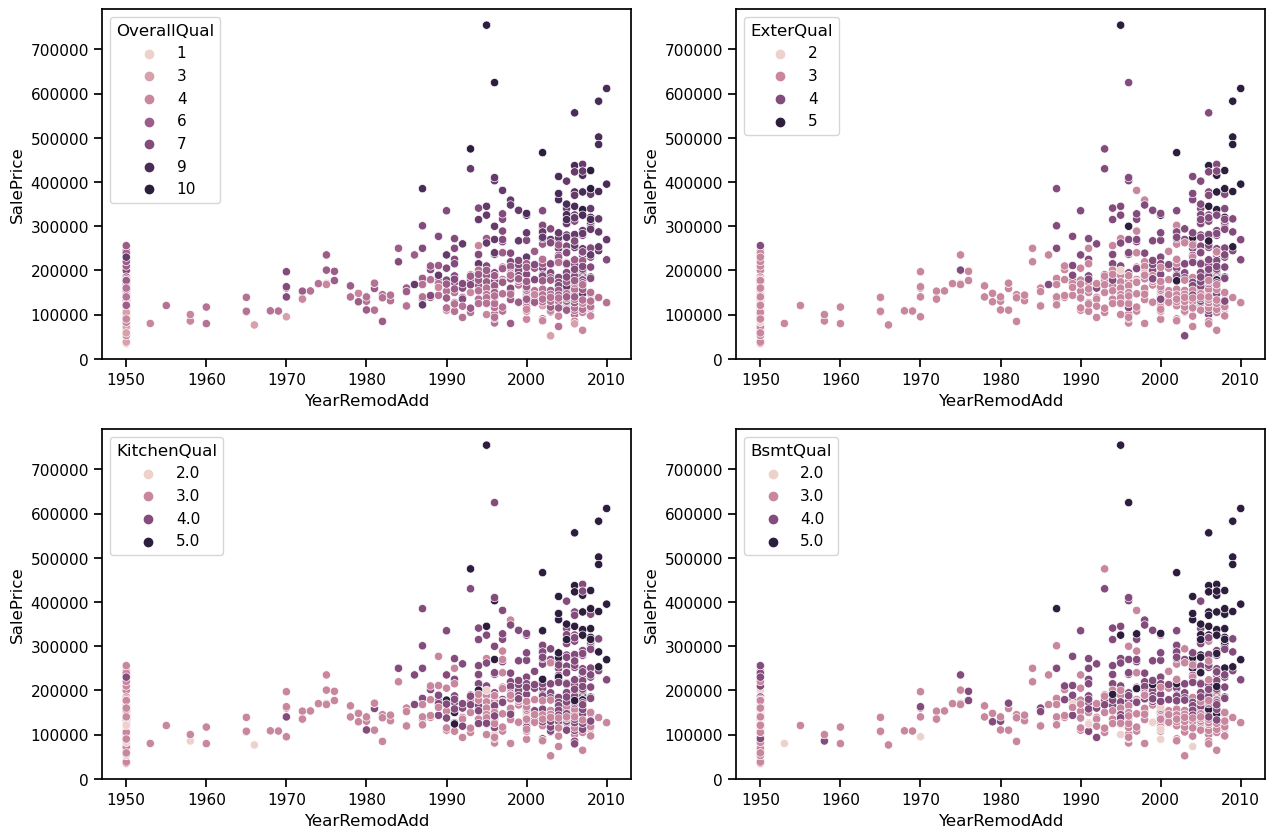

In [40]:
qualities = ['OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual']

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

df = total_set[total_set['YearRemodAdd'] != total_set['YearBuilt']]

for i in range(len(ax)) :
    sns.scatterplot(x='YearRemodAdd', y='SalePrice', hue=qualities[i], data=df, ax=ax[i])

plt.show()

Wait, why are there so many 1950 values for remodeling? Could that be a placeholder value, put in for any home older than 1950 that hasn't been remodeled? We already know that the remodeling column doesn't have nulls, so it's likely that all nulls were just put as 1950 for some reason.

Let's look at that.

<Axes: xlabel='YearBuilt', ylabel='YearRemodAdd'>

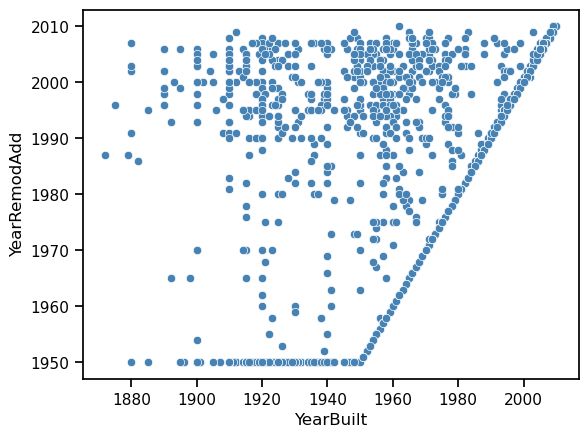

In [41]:
sns.scatterplot(x='YearBuilt', y='YearRemodAdd', data=total_set, color='steelblue')

No home built before 1950 has a remodel year before 1950.

Since there are no nulls in the remodel column (every single home on the list has a remodel year, even if it's equal to the build year), and no remodel years are less than 1950, and every single home built before 1950 has a remodel year of at least 1950, it's very likely that these homes were either never remodeled or remodeled before 1950, and the value 1950 is a placeholder.

Everything we do with these values is guesswork, so let's set them equal to the build year to avoid nulls and match at least part of the data.

Also, at least one home seems to have been remodeled BEFORE it was built. Let's clean that up at the same time.

<Axes: xlabel='YearBuilt', ylabel='YearRemodAdd'>

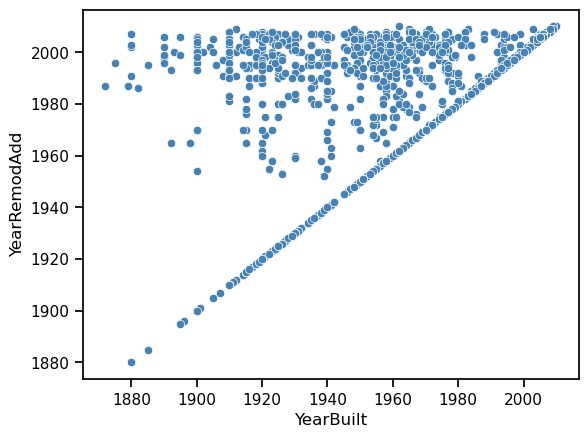

In [42]:
for index, row in total_set.iterrows() :
    if row['YearRemodAdd'] < row['YearBuilt'] or row['YearRemodAdd'] == 1950 :
        total_set.loc[index, 'YearRemodAdd'] = row['YearBuilt']
        
sns.scatterplot(x='YearBuilt', y='YearRemodAdd', data=total_set, color='steelblue')

---

'KitchenQual', 'ExterQual'

This one is subject to the idea mentioned earlier - all the quals are correlated, so we'll probably select just one and use it during modeling. No need to engineer this further at this point.

Step 3: Additional Feature Engineering
---

'LowQualFinSF' and 'BsmtUnfSF' seem like they could use some improvement.

Spefically, these values don't seem to be very significant on their own; they only make
sense as a RATIO of the total space. 500sf of unfinished space almost certainly has a
greater effect on the overall house price if 500sf is 100% of the house's area as opposed
to 10%.

Let's reengineer these features as ratios instead of normal measurements, and see if that
improves their correlation to the label.

C:\Users\Josh\AppData\Local\Temp\ipykernel_33756\3973449980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['LowQualFinRATIO'] = 0


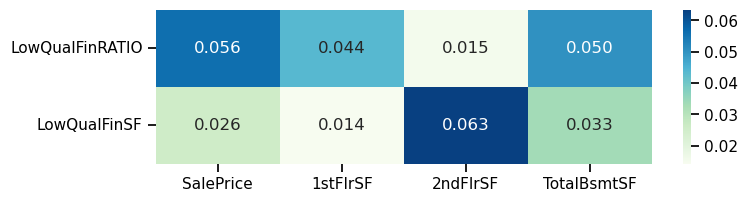

In [43]:
# 'LowQualFinSF' is probably best understood as a ratio of unfinished space / total space.
# Let's create that as a feature.

train_set['LowQualFinRATIO'] = 0

for index, value in train_set['LowQualFinSF'].items() :
    train_set.loc[index, 'LowQualFinRATIO'] = value / \
                                            (train_set.loc[index, '1stFlrSF'] + train_set.loc[index, '2ndFlrSF'] + \
                                             train_set.loc[index, 'TotalBsmtSF'])
    
corr_finder = train_set[['LowQualFinRATIO', 'LowQualFinSF', 'SalePrice', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']].corr()

corr_finder.iloc[:2] = corr_finder.iloc[:2].apply(abs)


plt.figure(figsize=(8, 2))
sns.heatmap(corr_finder.iloc[:2, 2:], annot=True, fmt='.3f', cmap='GnBu')
plt.show()

The ratio feature is twice as correlated to the label, and the correlations with other features seem to more or less cancel out.

Honestly, it's hard to say if this is having any affect at all. When it comes time for modeling, let's see if using one or the other improves performance.

C:\Users\Josh\AppData\Local\Temp\ipykernel_33756\699043147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['BsmtUnfRATIO'] = 0
C:\Users\Josh\AppData\Local\Temp\ipykernel_33756\699043147.py:6: RuntimeWarning: invalid value encountered in double_scalars
  train_set.loc[index, 'BsmtUnfRATIO'] = value / train_set.loc[index, 'TotalBsmtSF']


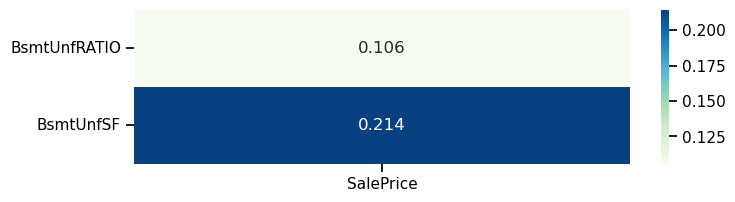

In [44]:
# Ditto for 'BsmtUnfSF'

train_set['BsmtUnfRATIO'] = 0

for index, value in train_set['BsmtUnfSF'].items() :
    train_set.loc[index, 'BsmtUnfRATIO'] = value / train_set.loc[index, 'TotalBsmtSF']

corr_finder = train_set[['BsmtUnfRATIO', 'BsmtUnfSF', 'SalePrice']].corr()

corr_finder.iloc[:2] = corr_finder.iloc[:2].apply(abs)

plt.figure(figsize=(8, 2))
sns.heatmap(corr_finder.iloc[:2, 2:], annot=True, fmt='.3f', cmap='GnBu')
plt.show()

Wow! Complete failure. Abort, abort!

In [45]:
train_set.drop('BsmtUnfRATIO', axis=1, inplace=True)

C:\Users\Josh\AppData\Local\Temp\ipykernel_33756\3969944618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.drop('BsmtUnfRATIO', axis=1, inplace=True)


I think I'm already well past the point of diminishing returns on feature engineering before I can see the results of the model, so let's leave it here for now and dig in deeper after we build some models.

Step 4: Save and Quit
---

In [46]:
# Let's implement some changes we made earlier.
total_set.drop(discarded_features, axis=1, inplace=True)

# Re-make our train and test splits including any modifications we may have made above.
step_2_train = total_set[total_set['set']=='train']
step_2_test = total_set[total_set['set']=='test'].drop('SalePrice', axis=1)

# Save and quit.
total_set.to_json('../data/interim/Step 2 - Total Set.json', orient='records')
step_2_train.to_json('../data/interim/Step 2 - Train Set.json', orient='records')
step_2_test.to_json('../data/interim/Step 2 - Test Set.json', orient='records')

Encore: Discarded Ideas
---

In [47]:
# 'Condition1' and 'Condition2' features are really talking about the same thing.
# If we don't combine them in some way, then the model will think that the values mean something
# different depending on which column they're in.
# Ideally, we'd one-hot encode each 'condition' separately.

# The code below would put them into a single list in a single column, but I'm not sure that's
# better. So, let's... shelve this for now.

# total_set['Conditions'] = ''

# for index, row in total_set.iterrows() :
#     con_list = []
#     con_1 = row['Condition1']
#     con_2 = row['Condition2']
#     if con_1 != 'Norm' :
#         con_list.append(con_1)
#     if con_2 != 'Norm' and con_1 != con_2 :
#         con_list.append(con_2)
#     if con_1 == 'Norm' and con_2 == 'Norm' :
#         total_set.at[index, 'Conditions'] = []
#     else :
#         total_set.at[index, 'Conditions'] = con_list

# # Clean house.
# total_set.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# # Peek peek.
# total_set['Conditions'].value_counts()

In [48]:
# # I suspect that the consumer's interest/reaction to this feature may not be linear.
# # If that's the case, then taking the log or exp of this feature may more accurately
# # model consumer behavior.
# # To test this, let's take the log and exp and see if that leads to a better correlation.

# # See how correlated the raw feature is.
# df = train_set[['Functional', 'SalePrice']].copy()
# basic_corr = df.corr().iloc[0, 1]
# print('Basic corr: '+str(basic_corr))

# # See if taking the log helps.
# log_df = train_set[['Functional', 'SalePrice']].copy()
# log_df['Functional'] = np.log(log_df['Functional'])
# improvement = (log_df.corr().iloc[0, 1] - basic_corr) * 100
# print('Log improvement %: '+str(improvement / basic_corr))

# # See if taking the exp helps.
# exp_df = train_set[['Functional', 'SalePrice']].copy()
# exp_df['Functional'] = np.exp(exp_df['Functional'])
# improvement = (exp_df.corr().iloc[0, 1] - basic_corr) * 100
# print('Exp improvement %: '+str(improvement / basic_corr))

# # Looks like using the exp value increases correlation by 6%.

In [49]:
# df = train_set[['GarageFinish', 'SalePrice']].copy()
# basic_corr = df.corr().iloc[0, 1]
# print('Basic corr: '+str(basic_corr))

# log_df = train_set[['GarageFinish', 'SalePrice']].copy()
# log_df['GarageFinish'] = np.log(log_df['GarageFinish'])
# improvement = (log_df.corr().iloc[0, 1] - basic_corr) * 100
# print('Log improvement %: '+str(improvement / basic_corr))

# exp_df = train_set[['GarageFinish', 'SalePrice']].copy()
# exp_df['GarageFinish'] = np.exp(exp_df['GarageFinish'])
# improvement = (exp_df.corr().iloc[0, 1] - basic_corr) * 100
# print('Exp improvement %: '+str(improvement / basic_corr))

# # This didn't seem to be the case here. 